In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import imagenet_utils
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [6]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 7s 0us/step


In [7]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [11]:
def prepare_image(file):
    img_path='D:/Acads/Coding/Machine Learning/Keras/dogs-vs-cats/train/'
    img = image.load_img(img_path + file, target_size = (224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis = 0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

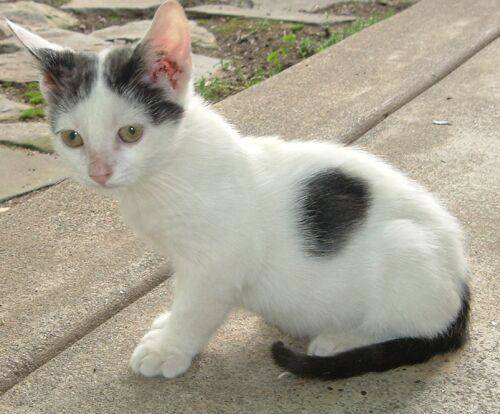

In [15]:
from IPython.display import Image
Image(filename='D:/Acads/Coding/Machine Learning/Keras/dogs-vs-cats/train/cat.3.JPG', width=300, height=200)

In [16]:
preprocessed_image = prepare_image('cat.3.JPG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n03958227', 'plastic_bag', 0.15318272),
  ('n02124075', 'Egyptian_cat', 0.11321202),
  ('n02123597', 'Siamese_cat', 0.10798512),
  ('n02123045', 'tabby', 0.07539202),
  ('n02909870', 'bucket', 0.05158636)]]

In [18]:
os.chdir('D:/Acads/Coding/Machine Learning/Keras/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in test_samples:
            shutil.move(f'train/{i}/{j}', f'test/{i}') 
        

In [19]:
train_path = 'D:/Acads/Coding/Machine Learning/Keras/Sign-Language-Digits-Dataset/train'
valid_path = 'D:/Acads/Coding/Machine Learning/Keras/Sign-Language-Digits-Dataset/valid'
test_path = 'D:/Acads/Coding/Machine Learning/Keras/Sign-Language-Digits-Dataset/test'

In [20]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                  directory=train_path, target_size = (224,224), batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                  directory=valid_path, target_size = (224,224), batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                  directory=test_path, target_size = (224,224), batch_size = 10)

Found 1462 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [21]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [23]:
x = mobile.layers[-6].output

In [24]:
output = Dense(units=10, activation='softmax')(x) #acts in the same way as F(x) and is known as functional model (such as VGG16 & mobeilnet)

In [25]:
model = Model(inputs = mobile.input, outputs = output)

In [26]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [51]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

In [52]:
model.fit(x=train_batches, validation_data=valid_batches, epochs = 10, verbose = 2)

Epoch 1/10
147/147 - 61s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0175 - val_accuracy: 0.9967
Epoch 2/10
147/147 - 75s - loss: 0.0041 - accuracy: 0.9993 - val_loss: 0.0168 - val_accuracy: 0.9933
Epoch 3/10
147/147 - 74s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 4/10
147/147 - 84s - loss: 6.9695e-04 - accuracy: 1.0000 - val_loss: 0.0134 - val_accuracy: 0.9933
Epoch 5/10
147/147 - 90s - loss: 4.6299e-04 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9933
Epoch 6/10
147/147 - 97s - loss: 4.0269e-04 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9967
Epoch 7/10
147/147 - 98s - loss: 1.9563e-04 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9967
Epoch 8/10
147/147 - 103s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 0.9833
Epoch 9/10
147/147 - 101s - loss: 0.0092 - accuracy: 0.9966 - val_loss: 0.0996 - val_accuracy: 0.9733
Epoch 10/10
147/147 - 100s - loss: 0.0032 - accuracy: 0.9993 - val_loss: 

In [46]:
predictions=np.round(model.predict(x=test_batches, verbose=0))

In [47]:
predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
test_batches.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [50]:
correct = 0
for i in range(len(test_batches.classes)):
    max_ind = 0
    max_prob = 0
    for j in range(len(predictions[i])):
        #print(predictions[i][j])
        if predictions[i][j] == 1:
            if j == test_batches.classes[i]:
                correct+=1
            break
print(correct*100/len(test_batches.classes))
print(len(test_batches.classes))

12.0
300
